## __Importing required frameworks__

In [0]:
import mxnet as mx
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn
from mxnet.gluon.data import vision
from matplotlib import pyplot as plt
import os

plt.style.use('seaborn')

ctx = mx.gpu()

## __Doing data augmentation and defining data loaders__

In [0]:
train_transform = vision.transforms.Compose([vision.transforms.RandomSaturation(saturation = 0.2),
                                             vision.transforms.RandomLighting(alpha = 0.2),
                                             vision.transforms.RandomHue(hue = 0.1),
                                             vision.transforms.RandomFlipLeftRight(),
                                             vision.transforms.RandomContrast(contrast = 0.2),
                                             vision.transforms.RandomColorJitter(brightness = 0.1, contrast = 0.1, saturation = 0.1, hue = 0.1),                                            
                                             vision.transforms.ToTensor()])

transform = vision.transforms.Compose([vision.transforms.ToTensor()])

train_cifar = gluon.data.vision.CIFAR10(train = True).transform_first(train_transform)
test_cifar = gluon.data.vision.CIFAR10(train = False).transform_first(transform)

In [0]:
batch_size = 64
train_data = gluon.data.DataLoader(train_cifar, batch_size = batch_size, shuffle = True)
test_data = gluon.data.DataLoader(test_cifar, batch_size = batch_size, shuffle = False)

In [4]:
for features, labels in train_data:
    break

print(f"features.shape: {features.shape}")
print(f"labels.shape: {labels.shape}")

print(f"features.max(): {features.max().asscalar()}")
print(f"features.min(): {features.min().asscalar()}")

features.shape: (64, 3, 32, 32)
labels.shape: (64,)
features.max(): 1.0
features.min(): 0.0


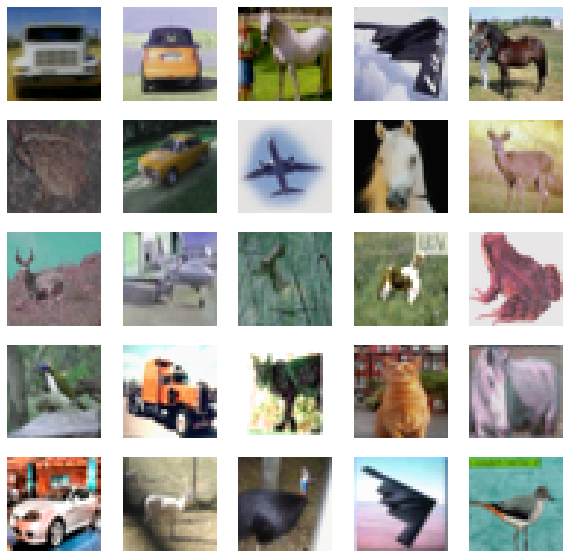

In [5]:
plt.figure(figsize = (10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(features[i].transpose((1, 2, 0)).asnumpy())
    plt.axis("off")
plt.show()

## __Defining model architecture__

In [6]:
model = nn.HybridSequential()

model.add(nn.Conv2D(32, (3, 3), padding = (1, 1)))
model.add(nn.LeakyReLU(0.2))
model.add(nn.BatchNorm())
model.add(nn.Conv2D(32, (3, 3), padding = (1, 1)))
model.add(nn.LeakyReLU(0.2))
model.add(nn.BatchNorm())
model.add(nn.MaxPool2D(pool_size=(2,2)))
model.add(nn.Dropout(0.2))

model.add(nn.Conv2D(64, (3, 3), padding = (1, 1)))
model.add(nn.LeakyReLU(0.2))
model.add(nn.BatchNorm())
model.add(nn.Conv2D(64, (3, 3), padding = (1, 1)))
model.add(nn.LeakyReLU(0.2))
model.add(nn.BatchNorm())
model.add(nn.MaxPool2D(pool_size=(2,2)))
model.add(nn.Dropout(0.3))

model.add(nn.Conv2D(128, (3, 3), padding = (1, 1)))
model.add(nn.LeakyReLU(0.2))
model.add(nn.BatchNorm())
model.add(nn.Conv2D(128, (3, 3), padding = (1, 1)))
model.add(nn.LeakyReLU(0.2))
model.add(nn.BatchNorm())
model.add(nn.MaxPool2D(pool_size=(2,2)))
model.add(nn.Dropout(0.4))

model.add(nn.Flatten())
model.add(nn.Dense(10))

model.initialize(mx.init.Xavier(), ctx)
model

HybridSequential(
  (0): Conv2D(None -> 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): LeakyReLU(0.2)
  (2): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
  (3): Conv2D(None -> 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): LeakyReLU(0.2)
  (5): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
  (6): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
  (7): Dropout(p = 0.2, axes=())
  (8): Conv2D(None -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): LeakyReLU(0.2)
  (10): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
  (11): Conv2D(None -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): LeakyReLU(0.2)
  (13): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_cha

## __Visualizing model architecture__

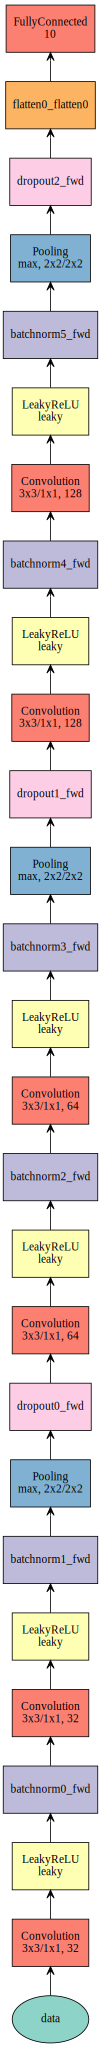

In [7]:
mx.viz.plot_network(model(mx.sym.var(name = 'data')), node_attrs = {'fixedsize': 'false'},)

## __Summarizing model layers__

In [8]:
model.summary(features.as_in_context(ctx))

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                             (64, 3, 32, 32)               0
            Conv2D-1                            (64, 32, 32, 32)             896
         LeakyReLU-2                            (64, 32, 32, 32)               0
         BatchNorm-3                            (64, 32, 32, 32)             128
            Conv2D-4                            (64, 32, 32, 32)            9248
         LeakyReLU-5                            (64, 32, 32, 32)               0
         BatchNorm-6                            (64, 32, 32, 32)             128
         MaxPool2D-7                            (64, 32, 16, 16)               0
           Dropout-8                            (64, 32, 16, 16)               0
            Conv2D-9                            (64, 64, 16, 16)           18496
        LeakyReLU-10        

## __Hybridizing and defining objective loss and optimizer__

In [0]:
model.hybridize()
objective = gluon.loss.SoftmaxCrossEntropyLoss()
optimizer = mx.optimizer.Adam(learning_rate = 0.0005)
trainer = gluon.Trainer(model.collect_params(), optimizer)
top1 = mx.metric.Accuracy()
top3 = mx.metric.TopKAccuracy(top_k = 3)

## __Training the model__

In [10]:
epochs = 50
batches = len(train_data)

train_losses = []
top1_accs = []
top3_accs = []

for epoch in range(epochs):
    top1.reset()
    top3.reset()
    cum_loss = 0.0
    for features, labels in train_data:
        features = features.as_in_context(ctx)
        labels = labels.as_in_context(ctx)

        with autograd.record():
            outputs = model(features)
            loss = objective(outputs, labels)
        loss.backward()
        trainer.step(batch_size)

        cum_loss += loss.mean()
        top1.update(labels, outputs)
        top3.update(labels, outputs)

    train_loss = cum_loss.asscalar()/batches
    top1_acc = top1.get()[1]
    top3_acc = top3.get()[1]

    train_losses.append(train_loss)
    top1_accs.append(top1_acc)
    top3_accs.append(top3_acc)
    
    print(f'Epoch: {epoch + 1} | Training Loss: {train_loss:.5f} | Top 1 Accuracy: {top1_acc:.5f} | Top 3 Accuracy: {top3_acc:.5f}')

Epoch: 1 | Training Loss: 2.11016 | Top 1 Accuracy: 0.35928 | Top 3 Accuracy: 0.69270
Epoch: 2 | Training Loss: 1.50723 | Top 1 Accuracy: 0.50814 | Top 3 Accuracy: 0.81704
Epoch: 3 | Training Loss: 1.25629 | Top 1 Accuracy: 0.58208 | Top 3 Accuracy: 0.86356
Epoch: 4 | Training Loss: 1.10212 | Top 1 Accuracy: 0.62728 | Top 3 Accuracy: 0.88730
Epoch: 5 | Training Loss: 0.99040 | Top 1 Accuracy: 0.66036 | Top 3 Accuracy: 0.90176
Epoch: 6 | Training Loss: 0.90590 | Top 1 Accuracy: 0.68728 | Top 3 Accuracy: 0.91484
Epoch: 7 | Training Loss: 0.85586 | Top 1 Accuracy: 0.70482 | Top 3 Accuracy: 0.92234
Epoch: 8 | Training Loss: 0.81036 | Top 1 Accuracy: 0.72168 | Top 3 Accuracy: 0.92828
Epoch: 9 | Training Loss: 0.76575 | Top 1 Accuracy: 0.73382 | Top 3 Accuracy: 0.93558
Epoch: 10 | Training Loss: 0.73097 | Top 1 Accuracy: 0.74596 | Top 3 Accuracy: 0.93894
Epoch: 11 | Training Loss: 0.70124 | Top 1 Accuracy: 0.75794 | Top 3 Accuracy: 0.94392
Epoch: 12 | Training Loss: 0.67406 | Top 1 Accuracy:

## __Visualizing model improvement throughout training__

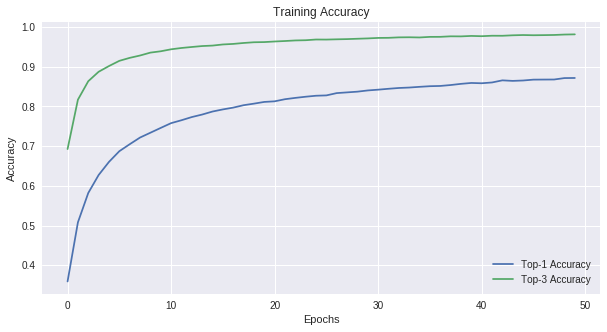

In [11]:
plt.figure(figsize = (10, 5))
plt.plot(top1_accs, label = 'Top-1 Accuracy')
plt.plot(top3_accs, label = 'Top-3 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()

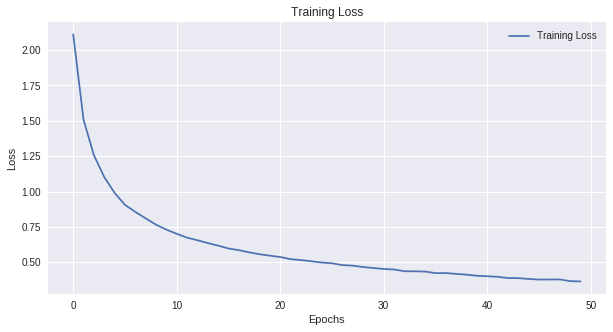

In [12]:
plt.figure(figsize = (10, 5))
plt.plot(train_losses, label = 'Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## __Testing the model__

In [13]:
top1.reset()
top3.reset()
for features, labels in test_data:
    features = features.as_in_context(ctx)
    labels = labels.as_in_context(ctx)
    outputs = model(features)
    top1.update(labels, outputs)
    top3.update(labels, outputs)
print(f'Testing Top-1 Accuracy: {top1.get()[1]}')
print(f'Testing Top-3 Accuracy: {top3.get()[1]}')

Testing Top-1 Accuracy: 0.8633
Testing Top-3 Accuracy: 0.9759
